1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [4]:
import numpy as np 
import pandas as pd 

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier


from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
from sklift.models import ClassTransformation
from sklift.models import TwoModels

import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')


In [9]:
import zipfile
with zipfile.ZipFile('./archive.zip', 'r') as zip_ref:
    zip_ref.extractall('./')


2. поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [10]:
df = pd.read_csv('data.csv', sep=',')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [11]:
df.rename(columns={'offer':'treatment', 'conversion':'target'}, inplace=True)
df.loc[df['treatment'] != 'No Offer', 'treatment'] = 1
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [12]:
cat_feature = ['zip_code', 'channel']

3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [13]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'),
                                                    df['target'],
                                                    test_size=0.25,  
                                                    random_state=42,
                                                    stratify=df['target'])

treat_train = X_train['treatment']
X_train.drop(columns=['treatment'], inplace=True)
treat_val = X_test['treatment']
X_test.drop(columns='treatment', inplace=True)

5. провести uplift-моделирование 3 способами:
    1. одна модель с признаком коммуникации (S-learner)
    2. модель с трансформацией таргета
    3. вариант с двумя независимыми моделями

In [14]:
metrics_df = pd.DataFrame(columns=['model', 'uplift@10%', 'uplift@20%'])
metrics_df

,model,uplift@10%,uplift@20%


## 1. Подход с одной моделью

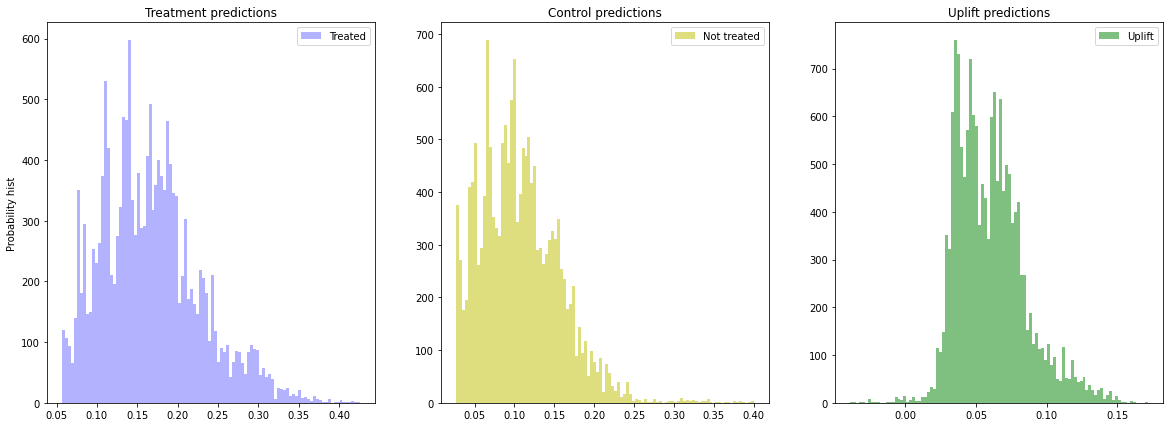

In [15]:
sm = SoloModel(CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_feature))

sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

metrics_df = metrics_df.append({
    'model': type(sm).__name__,
    'uplift@10%': sm_score_10,
    'uplift@20%': sm_score_20
}, ignore_index=True)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

### 1.2 Трансформация классов

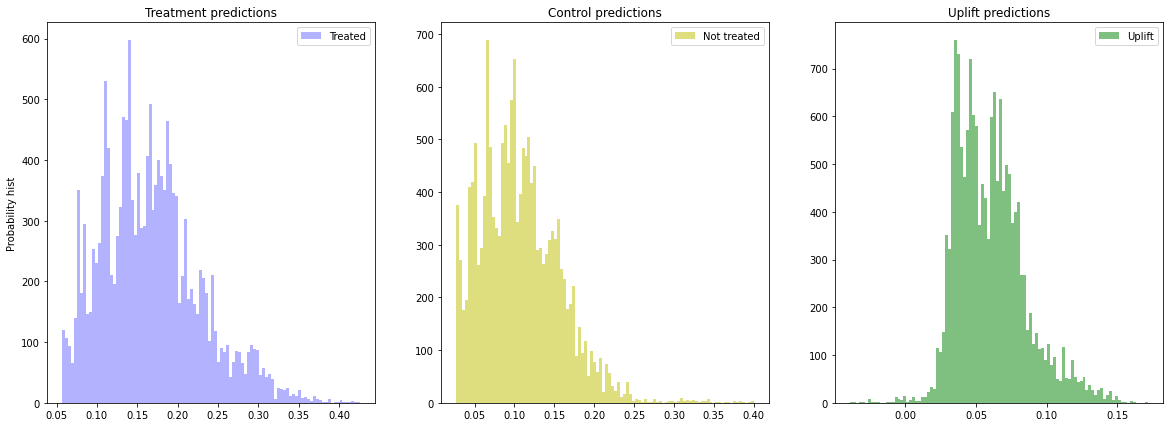

In [16]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_feature))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

metrics_df = metrics_df.append({
    'model': type(ct).__name__,
    'uplift@10%': ct_score_10,
    'uplift@20%': ct_score_20
}, ignore_index=True)


# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm.trmnt_preds_, ctrl_preds=sm.ctrl_preds_);

### 2. Две независимые модели

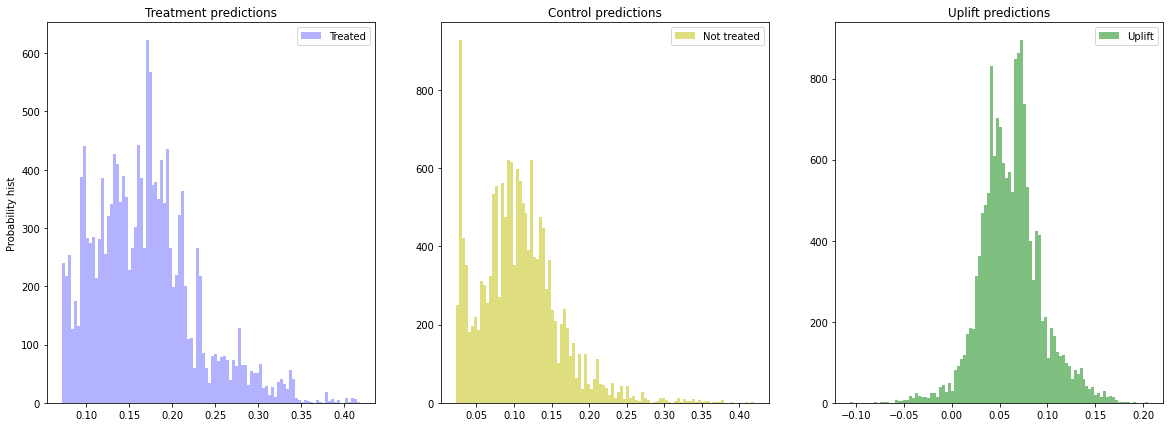

In [17]:
tm = TwoModels(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_feature),
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_feature),
    method='vanilla'  # независимые модели
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

metrics_df = metrics_df.append({
    'model': type(tm).__name__,
    'uplift@10%': tm_score_10,
    'uplift@20%': tm_score_20
}, ignore_index=True)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% 3 моделей

In [18]:
metrics_df

,model,uplift@10%,uplift@20%
0,SoloModel,0.099072,0.088734
1,ClassTransformation,0.091272,0.082507
2,TwoModels,0.104000,0.074360



8. *для модели S-learner построить зависимость таргета (конверсии - поле conversion) от значения uplift:
    1. сделать прогноз и получить uplift для тестовой выборки
    2. отсортировать тестовую выборку по uplift по убыванию
    3. разбить на децили (pandas qcut вам в помощь)
    4. для каждого дециля посчитать среднюю conversion

In [19]:
sm = SoloModel(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_feature)
)
sm = sm.fit(X_train, y_train, treat_train)
uplift_sm = sm.predict(X_test)

In [20]:
df_test = X_test.copy()
df_test['pred_uplift'] = uplift_sm
df_test['conversion'] = y_test
df_test.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,pred_uplift,conversion
55340,6,165.72,0,1,Surburban,0,Web,0.062095,0
50088,2,356.81,1,0,Surburban,1,Multichannel,0.042637,0
41899,12,59.53,1,0,Rural,0,Phone,0.067221,0
60235,11,316.64,1,0,Surburban,0,Web,0.039097,0
50752,1,397.63,0,1,Surburban,0,Web,0.077440,0


In [21]:
df_test = df_test.sort_values(by='pred_uplift', ascending=False)
df_test.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,pred_uplift,conversion
35723,1,1079.29,0,1,Rural,1,Multichannel,0.171815,0
38494,8,1087.73,0,1,Rural,1,Multichannel,0.162761,0
5428,1,822.69,0,1,Rural,1,Multichannel,0.160267,1
5343,1,796.97,0,1,Rural,1,Multichannel,0.160267,0
55047,1,821.30,0,1,Rural,1,Multichannel,0.160267,0


In [22]:
df_test['deciles'] = pd.qcut(df_test['pred_uplift'], q=10, labels=False)
df_test.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,pred_uplift,conversion,deciles
35723,1,1079.29,0,1,Rural,1,Multichannel,0.171815,0,9
38494,8,1087.73,0,1,Rural,1,Multichannel,0.162761,0,9
5428,1,822.69,0,1,Rural,1,Multichannel,0.160267,1,9
5343,1,796.97,0,1,Rural,1,Multichannel,0.160267,0,9
55047,1,821.30,0,1,Rural,1,Multichannel,0.160267,0,9


In [23]:
for i in range(0, 10):
    tmp = df_test[df_test['deciles'] == i]
    print(f'Для дециля {i} средняя конверсия равна {tmp["conversion"].mean():.3f}')

Для дециля 0 средняя конверсия равна 0.112
Для дециля 1 средняя конверсия равна 0.117
Для дециля 2 средняя конверсия равна 0.129
Для дециля 3 средняя конверсия равна 0.119
Для дециля 4 средняя конверсия равна 0.121
Для дециля 5 средняя конверсия равна 0.155
Для дециля 6 средняя конверсия равна 0.151
Для дециля 7 средняя конверсия равна 0.154
Для дециля 8 средняя конверсия равна 0.183
Для дециля 9 средняя конверсия равна 0.228


7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

Библиотека casualml тупо не ставится, проблема с ws c++. Танцы с бубном не помогли.
В целом, принцип работы - как у обычного дерева решений. Задает все подряд вопросы, выбирает из них тот, для которого больше критерий (только не Джини и не энтропия, а в нашем случае impurity).
И так далее, пока закончит по критерию останова - по глубине или количеству листьев.